In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim.models import Word2Vec
from joblib import load, dump

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [35]:
path_sentiment_data    = "../Data/PREP/sentiment_full.parquet"
path_merger_data       = "../Data/MERGERS/mergers.csv"

path_modelo_w2v        = '../Data/MODELS/modelo_word2vec_100.model'
path_modelo_clustering = '../Data/MODELS/clustering_pipeline.joblib'
path_modelo_logreg     = '../Data/MODELS/merger_logreg.joblib'

In [3]:
data = pd.read_parquet(path_sentiment_data)

In [37]:
def refactor_data(data):
    return (data
            .reset_index()
            .rename(columns={'sentences':'phrase', 'page':'n_page', 'sentence':'n_phrase'},)
            .set_index(['bank','year', 'n_page', 'n_phrase']))

def get_top_positive_phrases(data, count=20):
    data = refactor_data(data)
    preview = data.sort_values(by='positive', ascending=False).head(count)[['phrase']]
    return preview

def get_top_negative_phrases(data, count=20):
    data = refactor_data(data)
    preview = data.sort_values(by='negative', ascending=False).head(count)[['phrase']]
    return preview

def palabra_en_modelo(palabra,w2v):
    try:
        w2v.wv.get_vector(palabra)
        return True
    except:
        return False

def vectorize_text(texto_vector, w2v, SIZE_VECTORS=100):
    # Complete here the code
    vectors = [w2v.wv.get_vector(i) for i in texto_vector if palabra_en_modelo(i,w2v)]
    return np.mean(vectors, axis=0) if len(vectors) else np.zeros(SIZE_VECTORS)

def prepare_dataset(data, path_word2vec, path_clustering, SIZE_VECTORS=100):
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
    data = refactor_data(data)
    
    word2vec = Word2Vec.load(path_modelo_w2v)
    print('Tokenizing...')
    data['texto_vector'] = data.phrase.progress_apply(lambda x: [w.lower() for w in x.split(' ') if w])
    print('Aplicando Word2Vec...')
    vectors = data.texto_vector.progress_apply(lambda x: vectorize_text(x, word2vec, SIZE_VECTORS)).to_numpy()
    
    dfVectors = pd.DataFrame(np.concatenate(vectors).reshape(vectors.shape[0],SIZE_VECTORS,), index=data.index, 
                         columns=[f'WV{i}' for i in range(SIZE_VECTORS)])
    print('Aplicando Clustering...')
    clustering = load(path_modelo_clustering)
    clusters = clustering.predict(dfVectors)
    data['cluster'] = clusters
    data = data.dropna()
    print('Preparando Dataset...')
    ml_df = data.reset_index().groupby(['bank','year','cluster']).mean()[['positive','negative']].unstack('cluster')
    ml_df.columns = [sent[:3]+'_cluster_'+str(cluster)  for sent, cluster in ml_df.columns.values]
    ml_df = ml_df.fillna(0.0)
    
    return ml_df

def get_mergers(ml_df, path_merger_data):
    df_mergers = pd.read_csv(path_merger_data).dropna()
    df_mergers['YEAR'] = df_mergers['YEAR'].astype('int')
    df_mergers = df_mergers.set_index('YEAR')
    
    merger_target = []
    for bank, year in ml_df.index:
        merger_target.append(int(df_mergers[bank][int(year)]))
        
    return merger_target

def predict_merger(data, 
                   path_modelo_word2vec,
                   path_modelo_clustering,
                   path_modelo_merger,
                   timeit=True
                  ):
    import time
    from joblib import load
    total_time = 0
    if timeit: 
        start = time.time()
    X = prepare_dataset(data, path_modelo_word2vec, path_modelo_clustering)
    # Load del modelo:
    print('Cargando Modelo...')
    model = load(path_modelo_merger)
    print('Haciendo Predicción...')
    merger_pred = model.predict_proba(X)[:,1]
    if timeit: 
        end = time.time()
        total_time = end - start
        
    return merger_pred, total_time

In [6]:
X = prepare_dataset(data, path_modelo_w2v, path_modelo_clustering)
y = get_mergers(X, path_merger_data)

Tokenizing...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [00:06<00:00, 174658.02it/s]


Aplicando Word2Vec...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [01:03<00:00, 19049.51it/s]


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [23]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [24]:
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [25]:
model.fit(X_res, y_res)

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

### Checkpoint del Modelo:

In [36]:
dump(model, path_modelo_logreg)

['../Data/MODELS/merger_logreg.joblib']

In [26]:
model['logreg'].coef_

array([[-1.06697299, -1.24607649, -1.32978443,  0.16114794, -0.02093655,
         0.90065416,  0.62614672,  0.58214956,  0.0985781 , -0.16685029]])

In [27]:
y_pred = model.predict(X_test)

y_true = np.array(y_test)

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86        64
           1       0.12      0.67      0.20         3

    accuracy                           0.76        67
   macro avg       0.55      0.72      0.53        67
weighted avg       0.94      0.76      0.83        67



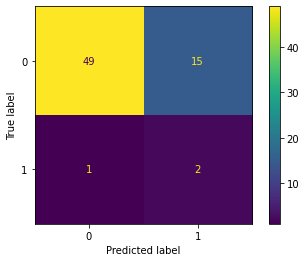

In [30]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

In [34]:
model.predict_proba(X_test)[:,1]

array([3.11634040e-01, 1.04534016e-01, 4.48056491e-01, 6.68037041e-05,
       7.58178362e-03, 4.61671315e-01, 1.60569747e-01, 5.52359465e-02,
       2.43180124e-01, 3.76385434e-01, 3.59548395e-01, 4.94334504e-01,
       5.22532306e-02, 4.91427632e-02, 2.45756162e-01, 3.62983282e-01,
       7.22848689e-01, 3.62875182e-02, 2.65633613e-01, 2.00914626e-01,
       4.31149702e-01, 5.26308449e-01, 6.69777738e-01, 8.12551871e-01,
       8.11993955e-01, 3.70960201e-01, 9.65162279e-02, 3.74489616e-01,
       6.90482250e-01, 4.38431277e-03, 4.64324764e-01, 4.40860221e-01,
       5.19068343e-01, 6.07255849e-01, 1.74534798e-01, 2.80727118e-01,
       8.49127955e-01, 2.00461560e-01, 1.83052840e-01, 7.79194882e-01,
       3.27476898e-01, 3.21098377e-01, 1.65996812e-03, 1.38953531e-01,
       2.60299823e-01, 3.76470169e-02, 2.02059923e-01, 1.79043787e-05,
       2.39006245e-02, 8.12416945e-01, 3.36972965e-01, 4.18993926e-01,
       5.84557023e-01, 4.17816000e-01, 4.78443956e-01, 8.36164858e-02,
      

In [38]:
res, time = predict_merger(data, 
               path_modelo_w2v,
               path_modelo_clustering,
               path_modelo_logreg,
               timeit=True
              )

Tokenizing...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [00:07<00:00, 171226.81it/s]


Aplicando Word2Vec...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [01:03<00:00, 18881.36it/s]


Aplicando Clustering...
Preparando Dataset...
Cargando Modelo...
Haciendo Predicción...
